In [87]:
# importamos las dependencias
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    make_scorer
)

[nltk_data] Downloading package punkt to /Users/trabajo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trabajo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/trabajo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importamos el dataset inicial y elejimos las 2 columnas que hemos decidido usar para el entrenamiento del modelo. 

In [88]:
starter_df = pd.read_csv("../data/youtoxic_english_1000.csv")
starter_df = starter_df[["Text", "IsToxic"]]

starter_df.head(5)

,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False


Imprimimos información básica del dataset y vemos que hay 1000 filas.

In [89]:
starter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     1000 non-null   object
 1   IsToxic  1000 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 8.9+ KB


Imprimmos la suma de cada variable en la columna "IsToxic" para ver el balanceo del dataset.

In [90]:
count_hate = (starter_df["IsToxic"] == True).sum()
count_no_hate = (starter_df["IsToxic"] == False).sum()
print(f"Hay {count_hate} comentarios de odio")
print(f"Hay {count_no_hate} comentarios sin odio")

Hay 462 comentarios de odio
Hay 538 comentarios sin odio


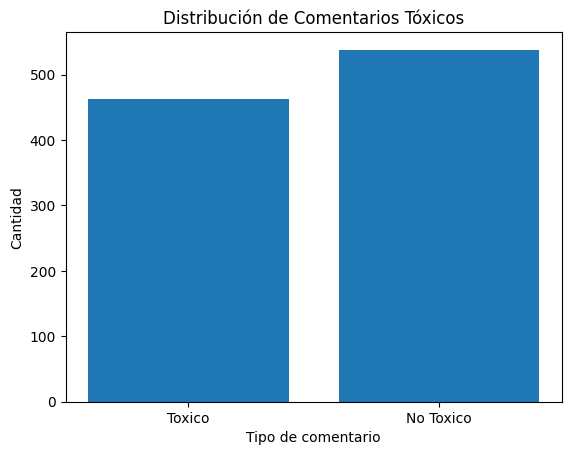

In [91]:
import matplotlib.pyplot as plt

labels = ['Toxico', 'No Toxico']
counts = [count_hate, count_no_hate]

plt.bar(labels, counts)
plt.title('Distribución de Comentarios Tóxicos')
plt.xlabel('Tipo de comentario')
plt.ylabel('Cantidad')

plt.show()

Como vemos el dataset está bastante balanceado pero al ser tan pocos datos el modelo puede tener problemas para predecir, por lo que decidimos incluir más datos desde [otro dataset de Kaggle.](https://www.kaggle.com/code/giovanimachado/hate-speech-bert-cnn-and-bert-mlp-in-tensorflow)

In [92]:
new_df = pd.read_csv("../data/labeled_data.csv")

new_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [93]:
count = (new_df["hate_speech"] == 0).sum()
count_1 = (new_df["hate_speech"] == 2).sum()

print(f"Hay {count} comentarios de odio en el nuevo dataset")
print(f"Hay {count_1} comentarios de no odio en el nuevo dataset")

Hay 19790 comentarios de odio en el nuevo dataset
Hay 1251 comentarios de no odio en el nuevo dataset


Vemos que este dataset tiene bastantes datos que podemos integrar en nuestro dataset. Decidimos traer 1250 filas random de cada tipo de dato, es decir cuando "hate_speech" sea 0 y 2, Sí, No, respectivamente. Lo guardamos en un nuevo archivo llamado extra_data.csv

In [94]:
# Filtrar y renombrar 1250 ejemplos de cada clase
df_0 = new_df[new_df["hate_speech"] == 0][["tweet", "hate_speech"]].sample(n=1250, random_state=42)
df_2 = new_df[new_df["hate_speech"] == 2][["tweet", "hate_speech"]].sample(n=1250, random_state=42)

nuevo_df = pd.concat([df_0, df_2], ignore_index=True)

nuevo_df = nuevo_df.rename(columns={
    "tweet": "Text",
    "hate_speech": "IsToxic"
})

# Crear columna booleana: True si es tóxico (hate_speech == 0), False si no (hate_speech == 2)
nuevo_df["IsToxic"] = nuevo_df["IsToxic"] == 0

nuevo_df.to_csv("../data/extra_data.csv", index=False)

print(nuevo_df.head(5))

                                                Text  IsToxic
0  @OptimusOdd mine will say "the intimidator" &#...     True
1  There are girls. There are women. There are la...     True
2                 @marshabitch don't start lil bitch     True
3  RT @ispeak_sarcasms: the nigga with no future ...     True
4  Meek do some nut shit one time he a bitch I gu...     True


In [95]:
nuevo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2500 non-null   object
 1   IsToxic  2500 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 22.1+ KB


Concatenamos el dataset extra_data.csv con nuestro dataset inicial.

In [96]:
extra_df = pd.read_csv("../data/extra_data.csv")
df = pd.concat([starter_df, extra_df], ignore_index=True)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     3500 non-null   object
 1   IsToxic  3500 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 30.9+ KB


Hay 1712 comentarios de odio
Hay 1788 comentarios sin odio


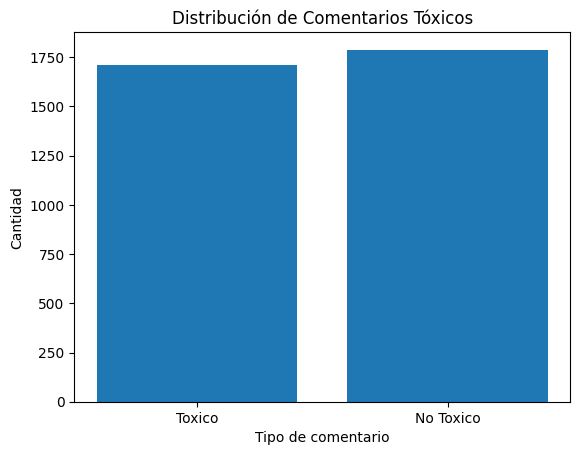

In [98]:
import matplotlib.pyplot as plt

count_hate = (df["IsToxic"] == True).sum()
count_no_hate = (df["IsToxic"] == False).sum()
print(f"Hay {count_hate} comentarios de odio")
print(f"Hay {count_no_hate} comentarios sin odio")

import matplotlib.pyplot as plt

labels = ['Toxico', 'No Toxico']
counts = [count_hate, count_no_hate]

plt.bar(labels, counts)
plt.title('Distribución de Comentarios Tóxicos')
plt.xlabel('Tipo de comentario')
plt.ylabel('Cantidad')

plt.show()


In [99]:
df.head(10)

,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False
5,here people his facebook is https://www.facebo...,True
6,"Check out this you tube post. ""Black man goes ...",True
7,I would LOVE to see this pussy go to Staten Is...,True
8,I agree with the protestor.,False
9,mike browns father was made to say that boooshit,True


Y hemos pasado de tener 1000 filas, a tener 3500 filas y sigue siendo un dataset balanceado.

In [79]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    tokens = nltk.word_tokenize(str(texto).lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['texto_limpio'] = df['Text'].apply(limpiar_texto)

vectorizer = TfidfVectorizer(
    max_features=150,
    min_df=35,
    max_df=0.6,
    ngram_range=(1, 2),
    sublinear_tf=True
)
X = vectorizer.fit_transform(df['texto_limpio'])
y = df['IsToxic'].astype(int)

modelo = LogisticRegression(C=0.06, max_iter=1000, class_weight="balanced")
f1_scorer = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(modelo, X, y, cv=5, scoring=f1_scorer)

print(f"\n=== Validación cruzada (F1, clase tóxica) ===")
print(f"F1-score promedio: {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
print("\n=== Evaluación en TRAIN ===")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_test_pred = modelo.predict(X_test)
print("\n=== Evaluación en TEST ===")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

f1_train = f1_score(y_train, y_train_pred, pos_label=1)
f1_test = f1_score(y_test, y_test_pred, pos_label=1)

overfitting_f1_pct = ((f1_train - f1_test) / f1_train) * 100 if f1_train != 0 else 0.0
print(f"F1-score TRAIN (clase tóxica): {f1_train:.3f}")
print(f"F1-score TEST  (clase tóxica): {f1_test:.3f}")
print(f"Overfitting (basado en F1): {overfitting_f1_pct:.2f}%")

def predict_true_false(prob):
    return prob >= 0.5

def predecir_toxicidad(texto):
    texto_limpio = limpiar_texto(texto)
    texto_vect = vectorizer.transform([texto_limpio])
    prob = modelo.predict_proba(texto_vect)
    print(f"Probabilidades de cada clase [no tóxico, tóxico]: {prob}")
    prob_toxico = prob[0][1]
    print(f"Probabilidad de toxicidad: {prob_toxico:.3f}")
    prediccion_final = predict_true_false(prob_toxico)
    return {
        "prediccion": prediccion_final,
        "probabilidad_toxico": round(prob_toxico, 3)
    }


=== Validación cruzada (F1, clase tóxica) ===
F1-score promedio: 0.605
Desviación estándar: 0.222

=== Evaluación en TRAIN ===
[[1145  285]
 [ 494  876]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1430
           1       0.75      0.64      0.69      1370

    accuracy                           0.72      2800
   macro avg       0.73      0.72      0.72      2800
weighted avg       0.73      0.72      0.72      2800


=== Evaluación en TEST ===
[[275  83]
 [131 211]]
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       358
           1       0.72      0.62      0.66       342

    accuracy                           0.69       700
   macro avg       0.70      0.69      0.69       700
weighted avg       0.70      0.69      0.69       700

F1-score TRAIN (clase tóxica): 0.692
F1-score TEST  (clase tóxica): 0.664
Overfitting (basado en F1): 4.15%


In [80]:
print(predecir_toxicidad("I love this product! It's amazing."))

Probabilidades de cada clase [no tóxico, tóxico]: [[0.55267616 0.44732384]]
Probabilidad de toxicidad: 0.447
{'prediccion': np.False_, 'probabilidad_toxico': np.float64(0.447)}


In [83]:
print(predecir_toxicidad("This song is terrible, I hate it."))

Probabilidades de cada clase [no tóxico, tóxico]: [[0.60261148 0.39738852]]
Probabilidad de toxicidad: 0.397
{'prediccion': np.False_, 'probabilidad_toxico': np.float64(0.397)}


Como vemos estas métricas no están del todo bien, porque el modelo no está prediciendo bien los casos Tóxicos.

Decidimos probar otro modelo, primero añadiendo datos con sinónimos, y usando Transformers para ver si las métricas mejoran.

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import nltk
from nltk.corpus import wordnet
from wordfreq import zipf_frequency

# Descargar recursos NLTK
nltk.download("wordnet")
nltk.download("omw-1.4")

device = torch.device("cpu")
print(f"🔧 Usando device: {device}")

def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([w for w in words if len(w)>3]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace("_", " ").lower()
                if synonym != word and zipf_frequency(synonym, "en") > 2:
                    synonyms.add(synonym)
        if len(synonyms) > 0:
            new_word = random.choice(list(synonyms))
            new_words = [new_word if w == word else w for w in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return " ".join(new_words)

df["IsToxic"] = df["IsToxic"].astype(int)

tox_df = df[df["IsToxic"] == 1]
augmented = []
for _, row in tox_df.sample(n=len(tox_df), replace=True, random_state=42).iterrows():
    augmented.append({
        "Text": synonym_replacement(row["Text"]),
        "IsToxic": 1
    })
aug_df = pd.DataFrame(augmented)
df_aug = pd.concat([df, aug_df], ignore_index=True)
print(f"Datos después de augmentation: {df_aug.shape}")

train_df, test_df = train_test_split(df_aug, test_size=0.2, stratify=df_aug["IsToxic"], random_state=42)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["Text"], truncation=True, padding="max_length", max_length=128)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_ds = train_ds.remove_columns(["Text", "__index_level_0__"]).rename_column("IsToxic", "labels")
test_ds = test_ds.remove_columns(["Text", "__index_level_0__"]).rename_column("IsToxic", "labels")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0)
    }

training_args = TrainingArguments(
    output_dir="./results",
    use_mps_device=True,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.1,
    logging_dir="./logs",
    logging_strategy="epoch"
)

from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],

)

trainer.train()

test_metrics = trainer.evaluate(eval_dataset=test_ds)
print("\n=== RESULTADOS EN TEST ===")
for k, v in test_metrics.items():
    print(f"{k}: {v:.3f}")

train_metrics = trainer.evaluate(eval_dataset=train_ds)
print("\n=== RESULTADOS EN TRAIN ===")
for k, v in train_metrics.items():
    print(f"{k}: {v:.3f}")

f1_train = train_metrics["eval_f1"]
f1_test = test_metrics["eval_f1"]
overfitting_pct = ((f1_train - f1_test) / f1_train) * 100 if f1_train != 0 else 0.0
print(f"\nOverfitting basado en F1: {overfitting_pct:.2f}%")

def predecir_toxicidad(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)[0].cpu().numpy()
    print(f"pred_toxico: {bool(probs[1] >= 0.5)}, prob_toxico: {round(float(probs[1]), 3)}, prob_no_toxico: {round(float(probs[0]), 3)}")

    return {
        "pred_toxico": bool(probs[1] >= 0.5),
        "prob_toxico": round(float(probs[1]), 3),
        "prob_no_toxico": round(float(probs[0]), 3)

    }

print(predecir_toxicidad("You're a disgusting human."))

El modelo da buenas métricas pero 9% de overfitting. 

TODO: mejorar el overfitting.